# Lung Cancer

## Get Radiomic Features from LIDC-IDRI

### Imports

In [ ]:
import pylidc as pl
from pylidc.utils import consensus
import SimpleITK as sitk
from radiomics import featureextractor
import pandas as pd
from imblearn.over_sampling import SMOTE
import statistics

### Get the dataset with all the features

In [ ]:

# Initialize the feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

# Get the list of additional features from pl.annotation_feature_names
additional_features = pl.annotation_feature_names

# Query the LIDC-IDRI dataset for scans with annotations
scans_with_annotations = pl.query(pl.Scan).filter(pl.Scan.annotations.any()).all()

# Lists to store the extracted features and patient IDs
features_list = []

# Variable to create unique IDs for the nodules
nodule_id_counter = 1

weights = {1: 0.18745, 2: 0.34375, 3: 0.65625, 4: 1.28125, 5: 2.53125}


# Iterating through all scans with annotations
for scan in scans_with_annotations:
    # Get the patient ID
    patient_id = scan.patient_id

    # Clusterize the annotations for the scan and retrieve all annotations
    nods = scan.cluster_annotations()

    # Iterating through all nodules of the patient
    for anns in nods:
        # Check if the current nodule has annotations
        if anns:
            # Convert consensus annotations into a mask
            cmask, _, _ = pl.utils.consensus(anns, clevel=0.5, pad=[(20, 20), (20, 20), (0, 0)])

            # Convert the pixel array to a SimpleITK image
            image = sitk.GetImageFromArray(cmask.astype(float))

            # Extract radiomic features using PyRadiomics
            features = extractor.execute(image, image, label=1)  # Use label 1 for the nodule

            # Add the patient ID to the features
            features['Patient_ID'] = patient_id

            # Add a unique ID for the nodule
            features['Nodule_ID'] = f'Nodule_{nodule_id_counter}'
            nodule_id_counter += 1

            def calculate_value(value):
                try:
                    return statistics.mode(value)
                except statistics.StatisticsError:
                    return np.mean(value)

            subtlety_value = calculate_value([ann.subtlety for ann in anns])
            internalStructure_value = calculate_value([ann.internalStructure for ann in anns])
            calcification_value = calculate_value([ann.calcification for ann in anns])
            sphericity_value = calculate_value([ann.sphericity for ann in anns])
            margin_value = calculate_value([ann.margin for ann in anns])
            lobulation_value = calculate_value([ann.lobulation for ann in anns])
            spiculation_value = calculate_value([ann.spiculation for ann in anns])
            texture_value = calculate_value([ann.texture for ann in anns])
            malignancy_value = [ann.malignancy for ann in anns]
            weighted_sum = sum(value*weights.get(value) for value in malignancy_value)
            total_weight = sum(weights.get(value) for value in malignancy_value)
            final_malignancy=0#weighted_sum/total_weight

            # Add the additional features to the features dictionary
            for feature_name in additional_features:
                features['subtlety'] = subtlety_value
                features['internalStructure'] = internalStructure_value
                features['sphericity'] = sphericity_value
                features['margin'] = margin_value
                features['lobulation'] = lobulation_value
                features['spiculation'] = spiculation_value
                features['texture'] = texture_value
                features['malignancy'] = final_malignancy

                # Access the feature values from the annotation
                if hasattr(anns[0], feature_name):
                    features[feature_name] = getattr(anns[0], feature_name)
                else:
                    # Handle cases where the feature is not available
                    features[feature_name] = None

            # Add the features to the list
            features_list.append(features)

        # Create a DataFrame to store the features
features_df = pd.DataFrame(features_list)

# Save the features to a CSV file
features_df.to_csv('radiomic_features.csv', index=False)


## Data Clean-up

In [ ]:
#Read and print the features dataset
df = pd.read_csv('radiomic_features.csv')
df

In [ ]:
#Check for null values
df.isna().sum()

In [ ]:
#Check if there are columns with only one value
df.nunique().tolist()

In [ ]:
#Get all columns with only one value
unique_value_counts = df.nunique()
columns_with_single_unique_value = unique_value_counts[unique_value_counts == 1].index
print(columns_with_single_unique_value)

In [ ]:
#Drop the selected columns
df.drop(columns=columns_with_single_unique_value,inplace=True)

In [ ]:
#Drop columns with tuples and IDs
df.drop(df.columns[0], axis=1, inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)
df.drop(df.columns[1], axis=1, inplace=True)
df.drop(df.columns[1], axis=1, inplace=True)
df.drop(df.columns[1], axis=1, inplace=True)
df.drop(df.columns[3], axis=1, inplace=True)
df.drop(df.columns[3], axis=1, inplace=True)
df.drop(df.columns[3], axis=1, inplace=True)
df.drop("Patient_ID", axis=1, inplace=True)
df.drop("Nodule_ID", axis=1, inplace=True)

In [ ]:
#Get the count of each value in malignancy column
df["malignancy"].value_counts()

In [ ]:
# Transform values of the malignancy column to 0 or 1
df = df[df['malignancy'] != 3]
df.loc[df['malignancy'].isin([1, 2]), 'malignancy'] = 0
df.loc[df['malignancy'].isin([4, 5]), 'malignancy'] = 1

In [ ]:
#Get the count of each value in malignancy column
df["malignancy"].value_counts()

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
df, _ = smote.fit_resample(df, df['malignancy'])

In [ ]:
df["malignancy"].value_counts()


In [ ]:
# Normalizing the columns using Min-Max scaling
df = df.drop(columns=df.select_dtypes(include=['object']))
df = (df - df.min()) / (df.max() - df.min())

In [ ]:
new_column_names = [
    'Mean',
    'VoxelNum',
    'VolumeNum',
    'Flatness',
    'LeastAxisLength',
    'MajorAxisLength',
    'DiameterColumn',
    'DiameterRow',
    'DiameterSlice',
    'Max3DDiameter',
    'MeshVolume',
    'MinorAxisLength',
    'Sphericity',
    'SurfaceArea',
    'SurfaceVolRatio',
    'VoxelVol',
    'Energy',
    'TotalEnergy',
    'DiffEntropy',
    'JointEntropy',
    'SumEntropy',
    'DependEntropy',
    'DependNonUniformity',
    'DependNonUniformityNorm',
    'DependVariance',
    'GrayLevelNonUniformity',
    'LargeDependEmphasis',
    'LargeDependHighGLEmphasis',
    'LargeDependLowGLEmphasis',
    'SmallDependEmphasis',
    'SmallDependHighGLEmphasis',
    'SmallDependLowGLEmphasis',
    'GLNonUniformity',
    'LongRunEmphasis',
    'LongRunHighGLEmphasis',
    'LongRunLowGLEmphasis',
    'RunEntropy',
    'RunLengthNonUniformity',
    'RunLenNonUniformityNorm',
    'RunPercentage',
    'RunVariance',
    'ShortRunEmphasis',
    'ShortRunHighGLEmphasis',
    'ShortRunLowGLEmphasis',
    'GLNonUniformity_GLSZM',
    'LargeAreaEmphasis',
    'LargeAreaHighGLEmphasis',
    'LargeAreaLowGLEmphasis',
    'SizeZoneNonUniformity',
    'SizeZoneNonUniformityNorm',
    'SmallAreaEmphasis',
    'SmallAreaHighGLEmphasis',
    'SmallAreaLowGLEmphasis',
    'ZoneEntropy',
    'ZonePercentage',
    'ZoneVariance',
    'Subtlety',
    'InternalStructure',
    'Calcification',
    'Sphericity',
    'Margin',
    'Lobulation',
    'Spiculation',
    'Texture',
    'Malignancy'
]

# Assign the new column names to the DataFrame
df.columns = new_column_names

In [ ]:
df

# Data Analysis

## Imports

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

## Data Overview and Cleaning

In [ ]:
df.head()

In [ ]:
# checking for null values in columns
missing_values = df.isnull().sum()

columns_with_missing = missing_values[missing_values > 0]
print(missing_values)

## Data Distribution

In [ ]:
# Create distribution plots for all columns (assuming they are all numerical)
# Adjust the number of subplots based on the number of columns
num_plots = len(df.columns)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(15, 5))

# Create histograms for all columns
for i, column in enumerate(df.columns):
    sns.histplot(df[column], ax=axes[i], kde=True)  # Use sns.histplot for a histogram with a KDE curve
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)

    # Increase the font size for x and y-axis labels
    axes[i].tick_params(axis='both', labelsize=12)  # Adjust the font size (e.g., 12)

plt.tight_layout()
plt.show()


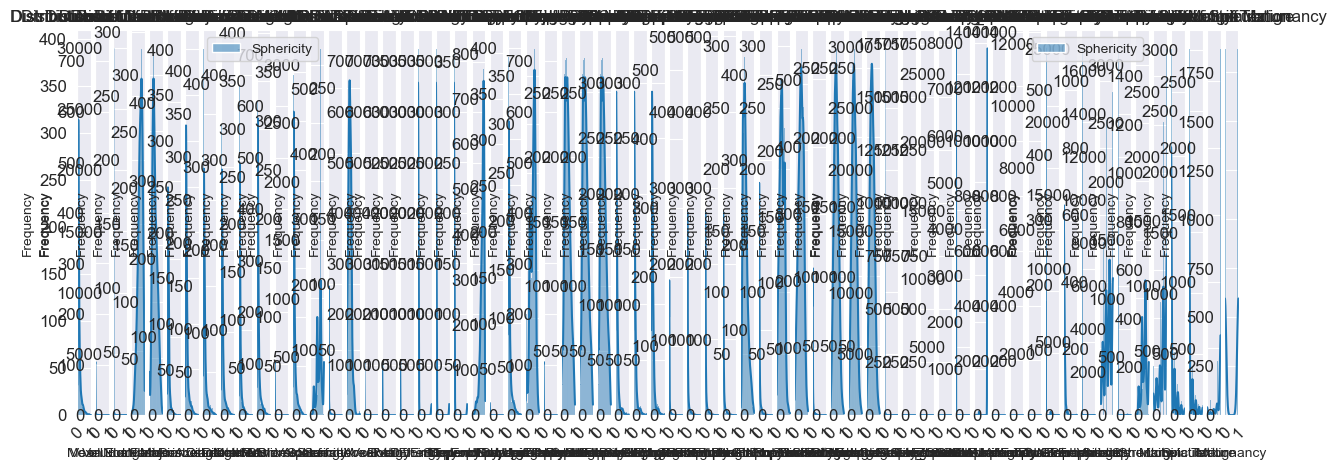

In [162]:
# Kernel Density Estimation (KDE) Plot
plt.figure(figsize=(8, 4))
sns.kdeplot(df['texture'], shade=True)
plt.title('Kernel Density Estimation Plot')
plt.xlabel('Texture')
plt.show()

In [163]:
# Violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(data=df, x='density', y='texture')
plt.title('Violin Plot of Pixel Intensity by Class')
plt.xlabel('density')
plt.ylabel('Texture')
plt.show()


KeyError: 'texture'

<Figure size 800x400 with 0 Axes>

In [ ]:
# Empirical Cumulative Distribution Function (ECDF) Plot columns_per_plot = 3
columns_per_plot = 6
# Function to create ECDF plots for a group of columns
def create_ecdf_plots(columns):
    plt.figure(figsize=(24, 11))
    
    for col in columns:
        x = np.sort(df[col])
        y = np.arange(1, len(x) + 1) / len(x)
        plt.plot(x, y, marker='.', linestyle='none', label=col)
    
    plt.title(f'ECDF Plot for Columns {columns[0]} to {columns[-1]}')
    plt.xlabel('Value')
    plt.ylabel('CDF')
    plt.legend()
    plt.margins(0.02)
    plt.show()
    
column_names = df.columns.tolist()

# Loop to create ECDF plots for groups of columns
for i in range(0, len(column_names), columns_per_plot):
    columns_to_plot = column_names[i:i + columns_per_plot]
    create_ecdf_plots(columns_to_plot)

## Correlation Analysis

In [ ]:
df.select_dtypes(include=['object'])
numeric_columns = df.select_dtypes(exclude=['object'])
correlation_matrix = numeric_columns.corr()

print(correlation_matrix)

In [ ]:
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()

In [ ]:
threshold = 0.7

strong_correlations = correlation_matrix[
    (correlation_matrix > threshold) & (correlation_matrix < 1)
    ]

print(strong_correlations)

## Feature Relationships

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create pair plots to explore relationships between numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64'])  # Select numerical features

# Customize the pair plot based on your preferences
sns.set(style="ticks")
pair_plot = sns.pairplot(numerical_features, diag_kind="kde")

# You can add additional customization options as needed, such as hue, markers, etc.
# Example:
# pair_plot = sns.pairplot(numerical_features, diag_kind="kde", hue="target_variable", markers=["o", "s", "D"])

# Show the pair plot
plt.show()


## Feature Importance

## Outliers and Anomalies

In [ ]:
# Calculate the Z-scores for each numerical feature------------------------------------not working
numeric_columns = df.select_dtypes(exclude=['object'])

z_scores = np.abs(stats.zscore(numeric_columns))

# Define a threshold for considering data points as outliers (e.g., Z-score > 3)
threshold = 3

# Identify and remove outliers
outliers = (z_scores > threshold).any(axis=1)
cleaned_data = df[~outliers]
cap_value = 3

# Alternatively, you can choose to impute or transform outliers instead of removing them
# Example for capping outliers to a specific value
cleaned_data['texture'] = np.where(z_scores > threshold, cap_value, cleaned_data['texture'])


## Data Preprocessing and Feature Engineering

## Summary and Insights

In [ ]:
df.select_dtypes(include=['object'])

In [ ]:
numeric_columns = df.select_dtypes(exclude=['object'])
correlation_matrix = numeric_columns.corr()

print(correlation_matrix)

In [ ]:

plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()

In [ ]:
correlation_matrix = numeric_columns.corr()

threshold = 0.7

strong_correlations = correlation_matrix[
    (correlation_matrix > threshold) & (correlation_matrix < 1)
]

print(strong_correlations)

## Classification

### Imports

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df

In [ ]:
X = df.iloc[:, :-1]  # Features (all columns except the last one)
y = df.iloc[:, -1]   # Target (the last column)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix


def testing(test,pred):
    accuracy = accuracy_score(test, pred)
    report = classification_report(test, pred, zero_division=1)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    heatmap(test,pred)
    
def heatmap(test,pred):
    cm = confusion_matrix(test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees (n_estimators)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [ ]:
testing(y_test,y_pred)

#### Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

In [ ]:
svclassifier = SVC()
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)

In [ ]:
testing(y_test,y_pred)

#### Naive Bayes

##### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

In [ ]:
testing(y_test,y_pred)

##### MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mult = MultinomialNB()
mult.fit(X_train, y_train)
y_pred = mult.predict(X_test)

In [ ]:
testing(y_test,y_pred)

##### BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bern = BernoulliNB()
bern.fit(X_train, y_train)
y_pred = bern.predict(X_test)

In [ ]:
testing(y_test,y_pred)

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lregress = LogisticRegression()
lregress.fit(X_train, y_train)
y_pred = lregress.predict(X_test)

In [ ]:
testing(y_test,y_pred)

#### XGBoost/LightGBM (Gradient Boosting)

##### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
testing(y_test,y_pred)

##### LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
testing(y_test,y_pred)